### Alumno: Óscar Mirones Alonso

**SEGMENTACIÓN AUTOMÁTICA DE NUCLEOS USANDO UNA U-NET**

La segmentación automática de imágenes de microscopía es una tarea importante en el procesamiento y análisis de imágenes médicas. La detección de núcleos es uno de los ejemplos más relevantes: Si se pudiera realizar de forma totalmente automatizada, se aceleraría la investigación de casi todas las enfermedades, desde el cáncer de pulmón y las enfermedades cardíacas hasta los trastornos raros. Usaremos un dataset de kaggle. Usaremos solo una pequeña muestra que podeis descargar [aqui](https://api.cloud.ifca.es:8080/swift/v1/datalabbio/datos_segmentacion.zip), pero el dataset completo está en kaggle y lo podéis descargar [aqui](https://api.cloud.ifca.es:8080/swift/v1/datalabbio/datos_segmentacion.zip).

Vamos a utilizar una u-net para realizar segmentación semántica. Os recomiendo que leais [este artículo](https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47). Además, encontraréis en él referencias al artículo orignal de la u-net por si hay alguien interesado :-). La u-net tiene una parte de codificación y otra de decodificación, que es la que le confiera esa forma de U que da lugar a su nombre.
![texto alternativo](https://miro.medium.com/max/1400/1*OkUrpDD6I0FpugA_bbYBJQ.png)

Vemos ahora un ejemplo de lo que queremos conseguir exactamente. Vemos una imagen de microscopio y debajo las imagenes de sus máscaras. Cuando la red esté entrenada, deberiamos poder meterle una imagen de microscopio nueva y que nos devuelva su máscara de capa donde en este caso habrá dos categorías: nucleo y no nucleo. Esta clasificación se hará pixel a pixel, y esto es justamente lo que se conoce como segmentación semántica. Esto nos permitiría contar núcleos de manera automática.

![texto alternativo](https://dl.acm.org/cms/attachment/3e2d2318-76a6-420b-b428-fc84e7ef9dc0/tomm1601-12-f01.jpg)

Como para esta práctica no vamos a tener acceso a todos los datos, solo me interesa que seais capaces de correr una u-net, que veais como se definen sus capas y entendais su arquitectura. No nos vamos a preocupar del resultado final porque para ello necesitariamos muchos más datos. 

Como métrica,para entrenar, vamos a utilizar la IoU media. Vimos lo que era la IoU (Intersection over Union) durante la clase de Machine Learning I, pero veamos aqui un pequeño recordatorio gráfico:
![texto alternativo](https://pyimagesearch.com/wp-content/uploads/2016/09/iou_equation.png)

Esto quiere decir que si lo hacemos perfecto, IoU sería igual a 1. La media de IoU es la media de la IoU para todas las imágenes del dataset. En esta práctica, y con las muestras que tenéis, aspiramos solo a tener un mean IoU entorno a 0.4.

In [47]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow,imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

# Vamos a definir algunos parámetros
BATCH_SIZE = 1 
IMG_WIDTH = 128 
IMG_HEIGHT = 128 
IMG_CHANNELS = 3

#Pon el path a tu carpeta de drive donde están los datos
TRAIN_PATH = 'drive/My Drive/cores_images/'


### *Preparando los datos*



In [0]:
# Aqui obtenemos una lista con los nombres de los directorios donde se encuentran los datos
train_ids = next(os.walk(TRAIN_PATH))[1]


In [54]:
# Obtener las imagenes y las máscaras de capa
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

print('Obteniendo y cambiando el tamaño de las imagenes y las máscaras de capa (etiquetas) ... ')
sys.stdout.flush()
#Fijaos en lo útil que es la función tqdm que nos permite tener una barra de estado para ir viendo la evolución
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask


print('Done!')

Obteniendo y cambiando el tamaño de las imagenes y las máscaras de capa (etiquetas) ... 





  0%|          | 0/25 [00:00<?, ?it/s]


  4%|▍         | 1/25 [00:00<00:12,  1.89it/s]


  8%|▊         | 2/25 [00:01<00:11,  1.93it/s]


 12%|█▏        | 3/25 [00:01<00:09,  2.33it/s]


 16%|█▌        | 4/25 [00:01<00:07,  2.79it/s]


 20%|██        | 5/25 [00:01<00:06,  3.10it/s]


 24%|██▍       | 6/25 [00:02<00:06,  2.99it/s]


 32%|███▏      | 8/25 [00:02<00:04,  3.93it/s]


 40%|████      | 10/25 [00:02<00:03,  4.08it/s]


 44%|████▍     | 11/25 [00:02<00:03,  4.18it/s]


 48%|████▊     | 12/25 [00:03<00:02,  4.35it/s]


 52%|█████▏    | 13/25 [00:03<00:02,  4.51it/s]


 56%|█████▌    | 14/25 [00:11<00:27,  2.51s/it]


 60%|██████    | 15/25 [00:11<00:18,  1.81s/it]


 64%|██████▍   | 16/25 [00:11<00:12,  1.34s/it]


 68%|██████▊   | 17/25 [00:11<00:08,  1.07s/it]


 72%|███████▏  | 18/25 [00:12<00:05,  1.24it/s]


 76%|███████▌  | 19/25 [00:12<00:03,  1.58it/s]


 80%|████████  | 20/25 [00:16<00:07,  1.58s/it]


 84%|████████▍ | 21/25 [00:17<00:06,  1.64s/it]


 92%|████████

Done!


### *Data augmentation*

In [0]:
from keras.preprocessing import image

seed = 14
#Crea los generadores y aplica data augmentation. 
#Mete modificaciones (rotaciones, reflejo especular, etc...) que tengan sentido en el caso de imagenes de microscopio. 
#Elige 4 o 5.
image_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2,
                                         width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')
mask_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2,
                                        width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')

# Aqui cogemos el 80% de la muestra para training

image_datagen.fit(X_train[:int(X_train.shape[0]*0.8)], augment=True, seed = seed)
mask_datagen.fit(Y_train[:int(Y_train.shape[0]*0.8)], augment=True, seed = seed)

x=image_datagen.flow(X_train[:int(X_train.shape[0]*0.8)],batch_size=BATCH_SIZE,shuffle=True, seed = seed)
y=mask_datagen.flow(Y_train[:int(Y_train.shape[0]*0.8)],batch_size=BATCH_SIZE,shuffle=True, seed = seed)



# Para validación vamos a hacer lo mismo, ahora nos quedaremos con el 20% **restante**
image_datagen_val = image.ImageDataGenerator()
mask_datagen_val = image.ImageDataGenerator()

image_datagen_val.fit(X_train[int(X_train.shape[0]*0.8):], augment=True, seed = seed)
mask_datagen_val.fit(Y_train[int(Y_train.shape[0]*0.8):], augment=True, seed = seed)

x_val=image_datagen_val.flow(X_train[int(X_train.shape[0]*0.8):],batch_size=BATCH_SIZE,shuffle=True, seed = seed)
y_val=mask_datagen_val.flow(Y_train[int(Y_train.shape[0]*0.8):],batch_size=BATCH_SIZE,shuffle=True, seed = seed)

Visualicemos las imágenes y las máscaras de capa

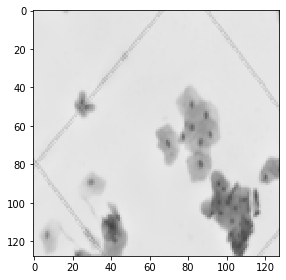

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


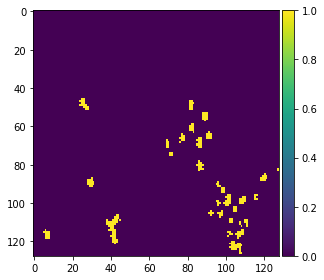

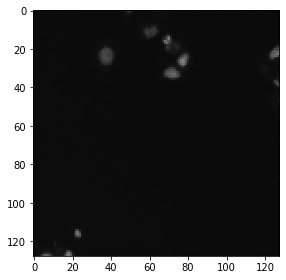

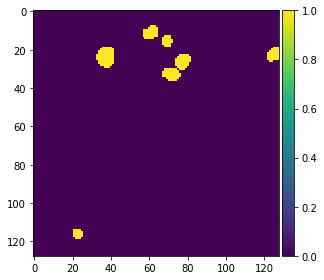

In [103]:
from matplotlib import pyplot as plt
%matplotlib inline

imshow(x.next()[0].astype(np.uint8))
plt.show()
imshow(np.squeeze(y.next()[0].astype(np.uint8)))
plt.show()
imshow(x_val.next()[0].astype(np.uint8))
plt.show()
imshow(np.squeeze(y_val.next()[0].astype(np.uint8)))
plt.show()

In [0]:
#Creamos un generador de train y de val que nos genere las imágenes y las máscaras
train_generator = zip(x, y)
val_generator = zip(x_val, y_val)

### *Construyendo el modelo u-net.*

 La estructura es distinta a como lo solemos hacer, fijaos en que a cada capa se le va diciendo explícitamente cual es la capa de input que tiene que coger. Esto se hace así porque si os fijais, en una U-net, la parte de decodificación necesita concatenar como input varias capas (fijaos en el gráfico de arriba donde se muestra la u-net). Atención a la nueva manera de normalizar el input según va entrando en la red. Usaremos de función de activación la función elu (exponential linear unit). Más información sobre esta función de activación [aqui](https://medium.com/@krishnakalyan3/introduction-to-exponential-linear-unit-d3e2904b366c).

In [105]:

inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
 
#Utiliza como metrica la IoU media (MeanIoU en Keras), y optimizador adam, y como función de pérdida ¿Qué función tiene sentido poner?
model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.MeanIoU(2)])
model.summary()

Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_17 (Lambda)              (None, 128, 128, 3)  0           input_17[0][0]                   
__________________________________________________________________________________________________
conv2d_305 (Conv2D)             (None, 128, 128, 16) 448         lambda_17[0][0]                  
__________________________________________________________________________________________________
dropout_145 (Dropout)           (None, 128, 128, 16) 0           conv2d_305[0][0]                 
___________________________________________________________________________________________

### *Entrenando*

In [106]:
# Mete early stopping y entrena durante 10 épocas. Recuerda meter también el generador de validación.
results = model.fit_generator(train_generator,validation_data=val_generator, epochs = 10,
                              steps_per_epoch = 255 ,
                              validation_steps=10, callbacks = [EarlyStopping(patience = 3)])



Epoch 1/10
255/255 [==============================] - 10s 38ms/step - loss: 0.4890 - mean_io_u_1: 0.4005 - val_loss: 0.2410 - val_mean_io_u_1: 0.4008
Epoch 2/10
255/255 [==============================] - 8s 30ms/step - loss: 0.2875 - mean_io_u_1: 0.4014 - val_loss: 0.1470 - val_mean_io_u_1: 0.4009
Epoch 3/10
255/255 [==============================] - 7s 29ms/step - loss: 0.2243 - mean_io_u_1: 0.4013 - val_loss: 0.1371 - val_mean_io_u_1: 0.4016
Epoch 4/10
255/255 [==============================] - 7s 29ms/step - loss: 0.1819 - mean_io_u_1: 0.4016 - val_loss: 0.2356 - val_mean_io_u_1: 0.4018
Epoch 5/10
255/255 [==============================] - 7s 29ms/step - loss: 0.1510 - mean_io_u_1: 0.4017 - val_loss: 0.0314 - val_mean_io_u_1: 0.4018
Epoch 6/10
255/255 [==============================] - 7s 28ms/step - loss: 0.1320 - mean_io_u_1: 0.4020 - val_loss: 0.1210 - val_mean_io_u_1: 0.4022
Epoch 7/10
255/255 [==============================] - 7s 29ms/step - loss: 0.1690 - mean_io_u_1: 0.4021 -

Observamos que, como durante 3 épocas no mejora, se detiene en la octava debido al early stopping.

### *Prediciendo*

Vamos a ver como quedarían algunas de las muestras de validación. Para ello repite lo que has hecho arriba y coge el 20% final de X_train.

5/5 [==============================] - 0s 3ms/step


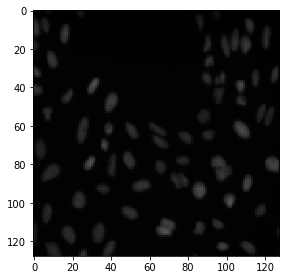

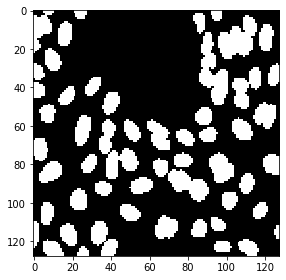

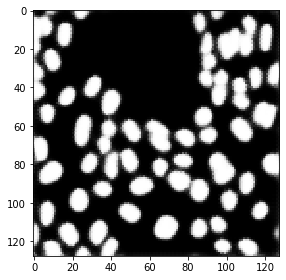

In [119]:
# Predecir en train y en validación
preds_val = model.predict(X_train[int(X_train.shape[0]*0.8):], verbose=1)
ix = random.randint(0, len(preds_val))
imshow(X_train[int(X_train.shape[0]*0.8):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.8):][ix]))
plt.show()
imshow(np.squeeze(preds_val[ix]))
plt.show()